# Descriptive statistics
This Notebook produces all tables for the descriptive statistics in the work.

In [16]:
# load the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from analysis_utils.plotting import *
from analysis_utils.describe_target import *
from analysis_utils.spatial_CV import *
from analysis_utils.analysis_helpers import demean_df
from analysis_utils.variable_names import *

from analysis_utils.flagged_uids import flagged_uids

import matplotlib

In [17]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [18]:
# set the root data directory
root_data_dir = "../../Data"
sat_img_dir = f"{root_data_dir}/satellite_imgs"

# Load the LSMS data
lsms_path = f"{root_data_dir}/lsms/processed/labels_cluster.csv"
lsms_full = pd.read_csv(lsms_path)
lsms_df = lsms_full.copy()
lsms_df_flagged = lsms_df[lsms_df['unique_id'].isin(flagged_uids)].copy().reset_index(drop=True)

# remove the flagged uids
lsms_df= lsms_df[~lsms_df['unique_id'].isin(flagged_uids)].reset_index(drop=True)

# normalise the asset indices
yeh_asset_var = 'mean_asset_index_yeh'
lsms_df[yeh_asset_var] = (lsms_df[yeh_asset_var] - lsms_df[yeh_asset_var].mean())/lsms_df[yeh_asset_var].std()
nate_asset_var = 'mean_asset_index_nate'
lsms_df[nate_asset_var] = (lsms_df[nate_asset_var] - lsms_df[nate_asset_var].mean())/lsms_df[nate_asset_var].std()

# add normalised target variables to the data
var_aux = 'mean_pc_cons_usd_2017' 
lsms_df['norm_mean_pc_cons_usd_2017'] = (lsms_df[var_aux] - lsms_df[var_aux].mean())/lsms_df[var_aux].std()

var_aux = 'log_mean_pc_cons_usd_2017' 
lsms_df['norm_log_mean_pc_cons_usd_2017'] = (lsms_df[var_aux] - lsms_df[var_aux].mean())/lsms_df[var_aux].std()

# add the cluster mean target variables to the dataset
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')

# load the feature data
feat_pth = f"{root_data_dir}/feature_data/tabular_data.csv"
feat_df = pd.read_csv(feat_pth)
feat_names = list(feat_df.columns)[2:]
feat_names = [i for i in feat_names if 'pc' not in i and 'mcf' not in i]

lsms_df = pd.merge(lsms_df, feat_df, on = ['unique_id','cluster_id'], how = 'left')

# demean the dataframe
demeaned_df = demean_df(lsms_df.copy())

# get the between dataframe
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars

between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation
cl_mean_target_vars = ['avg_log_mean_pc_cons_usd_2017', 'avg_mean_asset_index_yeh']

cl_df = lsms_df[['cluster_id'] + cl_mean_target_vars + between_x_vars].copy().drop_duplicates().reset_index(drop = True)

## Describe the dataset in general

In [19]:
# get the number of households in total
n_hh_df = lsms_df[['cluster_id', 'n_households']].drop_duplicates().reset_index(drop = True)
print(f"Number of households in the data {sum(n_hh_df['n_households'])}")
print(f"Number of Unique clusters in the data {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of cluster-year observations in the data {len(np.unique(lsms_df.unique_id))}")
print('\nNumber of households per cluster')
print(lsms_df['n_households'].describe())

Number of households in the data 17445
Number of Unique clusters in the data 2128
Number of cluster-year observations in the data 6401

Number of households per cluster
count    6401.000000
mean        7.701922
std         2.966513
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        16.000000
Name: n_households, dtype: float64


In [20]:
# bias by exclusion due to low satellite image quality
print(f"mean cons expenditure flagged ids:{np.mean(lsms_df_flagged['mean_pc_cons_usd_2017']):.2f}")
print(f"mean cons expenditure final sample:{np.mean(lsms_df['mean_pc_cons_usd_2017']):.2f}")

mean cons expenditure flagged ids:4.86
mean cons expenditure final sample:4.00


In [21]:
# distance between old and new geolocations
print("Distance between original and recentered locations")
coords = pd.read_csv("../../Data/lsms/processed/recentered_cluster_gps_v1.csv")
coords['dist'] = [haversine_distance(row['lat'], row['lon'], row['lsms_lat'], row['lsms_lon']) for idx, row in coords.iterrows()]
np.round(coords.dist.describe(),4)

Distance between original and recentered locations


count    2255.0000
mean        0.9832
std         1.1548
min         0.0000
25%         0.0381
50%         0.5707
75%         1.4789
max         7.8590
Name: dist, dtype: float64

## Descriptive statistics for outcome variables
gives common statistics for both target variables by country and overall for the full sample. 

In [22]:
# Describe the target variables by country (baseline only)

baseline_df = lsms_df.copy().sort_values(['cluster_id', 'unique_id'], ascending=[True, True]).groupby('cluster_id').first().reset_index()

print("Stats by country -- AT BASELINE")
print('mean & median & min & max & sd & n')

print("\nConsumption expenditure")

print("\nLog Consumption expenditure")
describe_target_cntry(baseline_df, 'log_mean_pc_cons_usd_2017')

print("\nAsset Index")
describe_target_cntry(baseline_df, 'mean_asset_index_yeh')

Stats by country -- AT BASELINE
mean & median & min & max & sd & n

Consumption expenditure

Log Consumption expenditure
\hspace{0.5cm} Ethiopia & 0.91 & 0.94 & -1.10 & 2.49 & 0.53 & 431 \\
\hspace{0.5cm} Malawi & 1.24 & 1.17 & 0.14 & 3.84 & 0.54 & 183 \\
\hspace{0.5cm} Nigeria & 1.42 & 1.40 & 0.20 & 3.75 & 0.51 & 419 \\
\hspace{0.5cm} Tanzania & 1.36 & 1.28 & 0.06 & 4.18 & 0.59 & 781 \\
\hspace{0.5cm} Uganda & 1.23 & 1.16 & -0.38 & 3.50 & 0.65 & 314 \\
\hspace{0.5cm} Overall & 1.25 & 1.21 & -1.10 & 4.18 & 0.60 & 2128 \\

Asset Index
\hspace{0.5cm} Ethiopia & -0.71 & -1.12 & -1.76 & 1.79 & 0.90 & 431 \\
\hspace{0.5cm} Malawi & -0.34 & -0.54 & -1.24 & 2.02 & 0.61 & 183 \\
\hspace{0.5cm} Nigeria & 0.35 & 0.35 & -1.25 & 2.95 & 0.81 & 419 \\
\hspace{0.5cm} Tanzania & 0.66 & 0.83 & -1.56 & 2.47 & 1.07 & 781 \\
\hspace{0.5cm} Uganda & -0.29 & -0.44 & -1.70 & 2.57 & 0.71 & 314 \\
\hspace{0.5cm} Overall & 0.09 & -0.08 & -1.76 & 2.95 & 1.06 & 2128 \\


In [23]:
# clusters below the poverty line: 
baseline_df['extreme_poor'].value_counts()/len(baseline_df)

for cntry in np.unique(baseline_df.country):
    cntry_df = baseline_df[baseline_df.country == cntry]
    print(cntry)
    print(f"{cntry_df['extreme_poor'].value_counts()/len(cntry_df)}")
    print("\n")

eth
0    0.508121
1    0.491879
Name: extreme_poor, dtype: float64


mwi
0    0.721311
1    0.278689
Name: extreme_poor, dtype: float64


nga
0    0.866348
1    0.133652
Name: extreme_poor, dtype: float64


tza
0    0.754161
1    0.245839
Name: extreme_poor, dtype: float64


uga
0    0.697452
1    0.302548
Name: extreme_poor, dtype: float64




In [24]:
# Describe the target variables by country (full sample)
print("Stats by country -- FULL SAMPLE")
print('mean & median & min & max & sd & n')

print("\nConsumption expenditure")
describe_target_cntry(lsms_df, 'mean_pc_cons_usd_2017')

print("\nLog Consumption expenditure")
describe_target_cntry(lsms_df, 'log_mean_pc_cons_usd_2017')

print("\nAsset Index")
describe_target_cntry(lsms_df, 'mean_asset_index_yeh')

Stats by country -- FULL SAMPLE
mean & median & min & max & sd & n

Consumption expenditure
\hspace{0.5cm} Ethiopia & 2.47 & 2.15 & 0.33 & 12.27 & 1.48 & 1187 \\
\hspace{0.5cm} Malawi & 4.13 & 3.19 & 1.15 & 46.51 & 3.87 & 366 \\
\hspace{0.5cm} Nigeria & 4.61 & 3.88 & 1.16 & 42.69 & 3.27 & 1167 \\
\hspace{0.5cm} Tanzania & 4.42 & 3.45 & 0.79 & 65.66 & 3.68 & 1951 \\
\hspace{0.5cm} Uganda & 4.13 & 2.95 & 0.52 & 45.64 & 3.60 & 1730 \\
\hspace{0.5cm} Overall & 4.00 & 3.08 & 0.33 & 65.66 & 3.38 & 6401 \\

Log Consumption expenditure
\hspace{0.5cm} Ethiopia & 0.75 & 0.77 & -1.10 & 2.51 & 0.56 & 1187 \\
\hspace{0.5cm} Malawi & 1.25 & 1.16 & 0.14 & 3.84 & 0.50 & 366 \\
\hspace{0.5cm} Nigeria & 1.37 & 1.36 & 0.15 & 3.75 & 0.53 & 1167 \\
\hspace{0.5cm} Tanzania & 1.30 & 1.24 & -0.24 & 4.18 & 0.57 & 1951 \\
\hspace{0.5cm} Uganda & 1.17 & 1.08 & -0.65 & 3.82 & 0.67 & 1730 \\
\hspace{0.5cm} Overall & 1.17 & 1.13 & -1.10 & 4.18 & 0.62 & 6401 \\

Asset Index
\hspace{0.5cm} Ethiopia & -0.74 & -1.05 & 

In [25]:
# Table 3: Decompose the variance into SSW and SSB
print("Consumption expenditure")
_ = decomp_SST(lsms_df, 'cluster_id', 'norm_mean_pc_cons_usd_2017')

print("\n\nLog Consumption Expenditure")
_ = decomp_SST(lsms_df, 'cluster_id', 'norm_log_mean_pc_cons_usd_2017')

print("\n\nAsset Index")
_ = decomp_SST(lsms_df, 'cluster_id', 'mean_asset_index_yeh')

Consumption expenditure
SSW = 1207.2256 - SSB = 5192.7744 - SST = 6400.0000 - SST directly calc = 6400.0000
Share of SSW = 0.1886 - Share of SSB = 0.8114

 Latex ouput (TSS, BSS, WSS, BSS (share), WSS (share))
norm_mean_pc_cons_usd_2017 & 6400 & 5192.77 & 1207.23 & 0.81 & 0.19


Log Consumption Expenditure
SSW = 919.3178 - SSB = 5480.6822 - SST = 6400.0000 - SST directly calc = 6400.0000
Share of SSW = 0.1436 - Share of SSB = 0.8564

 Latex ouput (TSS, BSS, WSS, BSS (share), WSS (share))
norm_log_mean_pc_cons_usd_2017 & 6400 & 5480.68 & 919.32 & 0.86 & 0.14


Asset Index
SSW = 199.8470 - SSB = 6200.1530 - SST = 6400.0000 - SST directly calc = 6400.0000
Share of SSW = 0.0312 - Share of SSB = 0.9688

 Latex ouput (TSS, BSS, WSS, BSS (share), WSS (share))
mean_asset_index_yeh & 6400 & 6200.15 & 199.85 & 0.97 & 0.03


In [26]:
# table for different target variables

print("\multicolumn{7}{l}{Panel A: consumption expenditure (\$/pc/day)}\\\\")
describe_target(lsms_df, 'log_mean_pc_cons_usd_2017', var_name = '$w_{ct}$')
describe_target(cl_df, 'avg_log_mean_pc_cons_usd_2017', var_name = '$\widebar{w}_c$')
describe_target(demeaned_df, 'log_mean_pc_cons_usd_2017', var_name = '$\widetilde{w}_{ct}$')
print("\\vspace{0cm}\\\\")
print("\multicolumn{7}{l}{Panel B: asset wealth index}\\\\")
describe_target(lsms_df, 'mean_asset_index_yeh', var_name = '$w_{ct}$')
describe_target(cl_df, 'avg_mean_asset_index_yeh', var_name = '$\widebar{w}_c$')
describe_target(demeaned_df, 'mean_asset_index_yeh', var_name = '$\widetilde{w}_{ct}$')

\multicolumn{7}{l}{Panel A: consumption expenditure (\$/pc/day)}\\
	\hspace{0.5cm} $w_{ct}$ &   1.17 &  1.13 &  -1.10 &  4.18 &  0.62 &  6401 \\
	\hspace{0.5cm} $\widebar{w}_c$ &   1.20 &  1.15 &  -0.72 &  4.07 &  0.57 &  2128 \\
	\hspace{0.5cm} $\widetilde{w}_{ct}$ &   0.00 &  -0.00 &  -1.04 &  1.97 &  0.24 &  6401 \\
\vspace{0cm}\\
\multicolumn{7}{l}{Panel B: asset wealth index}\\
	\hspace{0.5cm} $w_{ct}$ &   -0.00 &  -0.25 &  -1.76 &  2.95 &  1.00 &  6401 \\
	\hspace{0.5cm} $\widebar{w}_c$ &   0.15 &  0.01 &  -1.72 &  2.79 &  1.04 &  2128 \\
	\hspace{0.5cm} $\widetilde{w}_{ct}$ &   -0.00 &  -0.00 &  -1.57 &  1.15 &  0.18 &  6401 \\


## Descriptive statistics for selected predictors

In [27]:
# descriptive statistics for predictors
px_to_km2_factor = 30 * 30 / (1000 * 1000)
lsms_df['precip_l'] = lsms_df['precipitation'] / 1000

print("\multicolumn{8}{l}{Panel A: dynamic predictors}\\\\")
describe_var(lsms_df, 'dyn_nl_mean', var_name = 'nightlights mean')
describe_var(lsms_df, 'dyn_ndvi_mean', var_name = 'ndvi mean')
describe_var(lsms_df, 'dyn_ndwi_gao_mean', var_name = 'ndwi mean')
describe_var(lsms_df, 'precip_l', var_name = 'precipitation (l)')
describe_var(lsms_df, 'dyn_rgb_pc_1', var_name = 'rgb ls pc 1')

print("\\vspace{0cm}\\\\")
print("\multicolumn{8}{l}{Panel B: static predictors}\\\\")
describe_var(cl_df, 'wsf_mean', var_name = 'wsf mean')
describe_var(cl_df[['built_up']]*px_to_km2_factor, 'built_up', var_name = 'built up (km^2)')
describe_var(cl_df[['cropland']]*px_to_km2_factor, 'cropland', var_name = 'cropland (km^2)')
describe_var(cl_df[['tree']]*px_to_km2_factor, 'tree', var_name = 'tree (km^2)')
describe_var(cl_df[['distance_paved_road']]/1000, 'distance_paved_road', var_name = 'D paved road (km)')
describe_var(cl_df[['fuel_dist']]/1000, 'fuel_dist', var_name = 'D gas station (km)')
describe_var(cl_df, 'fuel_count', var_name = '# gas station')
describe_var(cl_df[['road_length_road']]/1000, 'road_length_road', var_name = 'road network length (km)')



\multicolumn{8}{l}{Panel A: dynamic predictors}\\
	\hspace{0.5cm}nightlights mean & 0.01 & 0.00 & 0.34 & 0.07 & 0.01 & 0.04 & 6401 \\
	\hspace{0.5cm}ndvi mean & 0.30 & -0.04 & 0.52 & 0.15 & 0.02 & 0.08 & 6401 \\
	\hspace{0.5cm}ndwi mean & 0.10 & -0.12 & 0.31 & 0.13 & 0.01 & 0.07 & 6401 \\
	\hspace{0.5cm}precipitation (l) & 1.17 & 0.23 & 3.22 & 0.72 & 0.16 & 0.43 & 6401 \\
	\hspace{0.5cm}rgb ls pc 1 & 0.02 & -1.57 & 3.76 & 1.67 & 0.33 & 1.00 & 6401 \\
\vspace{0cm}\\
\multicolumn{8}{l}{Panel B: static predictors}\\
	\hspace{0.5cm}wsf mean & 0.17 & 0.00 & 0.96 &   &   & 0.23 & 2128 \\
	\hspace{0.5cm}built up (km^2) & 4.82 & 0.00 & 43.91 &   &   & 8.66 & 2128 \\
	\hspace{0.5cm}cropland (km^2) & 12.42 & 0.00 & 44.79 &   &   & 13.13 & 2128 \\
	\hspace{0.5cm}tree (km^2) & 8.80 & 0.00 & 44.86 &   &   & 10.52 & 2128 \\
	\hspace{0.5cm}D paved road (km) & 9.92 & 0.00 & 245.26 &   &   & 16.60 & 2128 \\
	\hspace{0.5cm}D gas station (km) & 22.59 & 0.01 & 226.20 &   &   & 26.34 & 2128 \\
	\hspace{0.5

## Exemplary data split
This snippet performs an exemplary split of the data using spatial cross-validation. This is used in R to make exemplary plots.

In [28]:
# set the random seed
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

# do the spatial CV split
fold_ids = split_lsms_spatial(lsms_df, n_folds = n_folds, random_seed = spatial_cv_random_seed)

# store the split to the data
ex_split_df = lsms_df.copy()
ex_split_df['val_fold'] = pd.Series([k for i in ex_split_df['cluster_id'] for k, v in fold_ids.items() if i in v['val_ids']])    

ex_split_df.to_csv('../../Data/lsms/processed/ex_cv_split.csv', index = False)

Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16


# Plot static satellite images

In [29]:
cluster_id = 'uga_3040004'

In [30]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

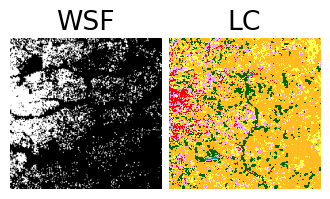

In [34]:
# plot satic statellite iamges
sat_img_dir = "../../Data/satellite_imgs"
rs_mean_image_dir = f"{sat_img_dir}/RS_v2/RS_v2_between"

# cmap for lc:
esa_colors = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000',
          '#b4b4b4', '#0096a0', '#0064c8']
esa_cmap = plt.cm.colors.ListedColormap(esa_colors)

# create cmap list:
cmap_list = ['gray', esa_cmap]

# load the RS image
rs_file_name = 'RS_v2_'+cluster_id+".npy"
rs_img_pth = os.path.join(rs_mean_image_dir, rs_file_name)
rs_img = np.load(rs_img_pth)

rows = 1
cols = 2

data_names = ['WSF', 'LC']
    
fig, ax = plt.subplots(rows, cols, figsize=(4, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05) 

rs_img = rs_img[:,:,3:]

for i in range(rs_img.shape[2]):
    ax[i].imshow(rs_img[:,:,i],cmap = cmap_list[i])
    ax[i].set(xticks=[], yticks=[])
    ax[i].set_title(data_names[i])
    ax[i].spines[['right', 'left', 'bottom', 'top']].set_visible(False)


pth = '../figures/tabular_features/static_features.png'
plt.savefig(pth, dpi = 500, bbox_inches = 'tight')

# Plot dynamic images

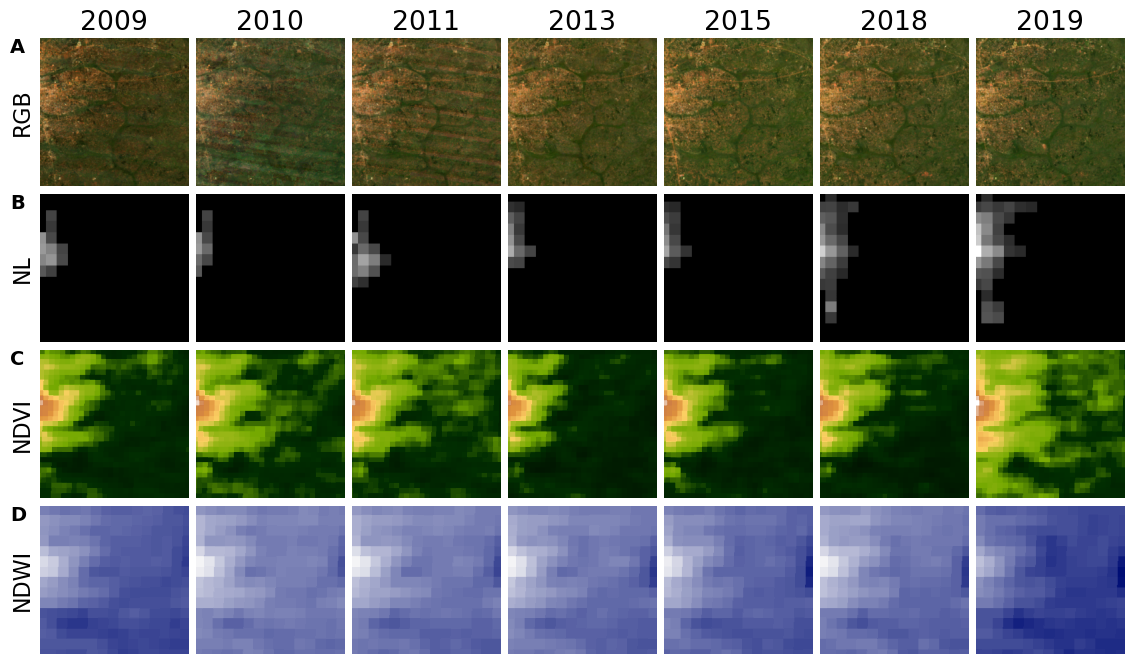

In [35]:
# make plot over time
sat_img_dir = "../../Data/satellite_imgs"

rgb_image_dir = f"{sat_img_dir}/LS/LS_rgb"
rs_image_dir = f"{sat_img_dir}/RS_v2/RS_v2_dynamic_processed"

# list all files in image directory
files = np.array(os.listdir(rs_image_dir))
mask = [cluster_id in i for i in files]
rs_file_names = np.sort(files[mask])

# list all RGB images in directory
files = np.array(os.listdir(rgb_image_dir))
mask = [cluster_id in i for i in files]
rgb_file_names = np.sort(files[mask])

# ndvi color palette:
ndvi_cols = [
    '#ffffff', '#ce7e45', '#df923d', '#f1b555', '#fcd163', '#99b718', '#74a901',
    # '#66a000', '#529400', '#3e8601', '#207401', '#056201', '#004c00', '#023b01',
    '#012e01', '#011d01', '#011301']
ndvi_cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ndvi_cols, N=256)

# ndwi color palette:
ndwi_cols = ['#F4F4F6', '#000E75']

# Create a custom colormap using the defined color palette
ndwi_cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ndwi_cols, N=64)

num_images = len(rgb_file_names)
rows = 4
cols = num_images

# get the mins and maxs for all image channels
mins = []
maxs = []
for i in range(num_images):
    rs_file_pth = os.path.join(rs_image_dir, rs_file_names[i])
    rs_img = np.load(rs_file_pth)
    img_mins = []
    img_maxs = []
    for band_idx in range(rs_img.shape[2]):
        img_mins.append(np.min(rs_img[:,:,band_idx]))
        img_maxs.append(np.max(rs_img[:,:,band_idx]))
    mins.append(img_mins)
    maxs.append(img_maxs)
mins = np.min(np.array(mins), axis = 0)
maxs = np.max(np.array(maxs), axis = 0)




fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05) 

for i in range(num_images):
    year = rgb_file_names[i][-8:-4]
    rgb_file_pth = os.path.join(rgb_image_dir, rgb_file_names[i])
    rgb_img = np.load(rgb_file_pth)
    plot_rgb(rgb_img, ax = ax[0,i])
    ax[0,i].set_title(f"{year}")
    
    rs_file_pth = os.path.join(rs_image_dir, rs_file_names[i])
    rs_img = np.load(rs_file_pth)
    ax[1,i].imshow(rs_img[:,:,0], cmap = 'gray', vmin = mins[0], vmax = maxs[0])
    ax[1,i].set(xticks=[], yticks=[])

    ax[2,i].imshow(rs_img[:,:,1], cmap=ndvi_cmap, vmin =mins[1], vmax = maxs[1])
    ax[2,i].set(xticks=[], yticks=[])

    ax[3,i].imshow(rs_img[:,:,2], cmap = ndwi_cmap, vmin =mins[2], vmax = maxs[2])
    ax[3,i].set(xticks=[], yticks=[])
    
    ax[0,i].spines[['right', 'left', 'bottom', 'top']].set_visible(False)
    ax[1,i].spines[['right', 'left', 'bottom', 'top']].set_visible(False)
    ax[2,i].spines[['right', 'left', 'bottom', 'top']].set_visible(False)
    ax[3,i].spines[['right', 'left', 'bottom', 'top']].set_visible(False)
    


ax[0,0].set_ylabel("RGB")
ax[1,0].set_ylabel("NL")
ax[2,0].set_ylabel("NDVI")
ax[3,0].set_ylabel("NDWI")

text_y = .9
text_x = -.2
ax[0,0].text(text_x, text_y, 'A', transform=ax[0,0].transAxes, weight='bold', size = 14)
ax[1,0].text(text_x, text_y, 'B', transform=ax[1,0].transAxes, weight='bold', size = 14)
ax[2,0].text(text_x, text_y, 'C', transform=ax[2,0].transAxes, weight='bold', size = 14)
ax[3,0].text(text_x, text_y, 'D', transform=ax[3,0].transAxes, weight='bold', size = 14)

pth = '../figures/tabular_features/feats.png'
plt.savefig(pth, dpi = 500, bbox_inches = 'tight')

## Plot the target variables over time for the same cluster

In [36]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

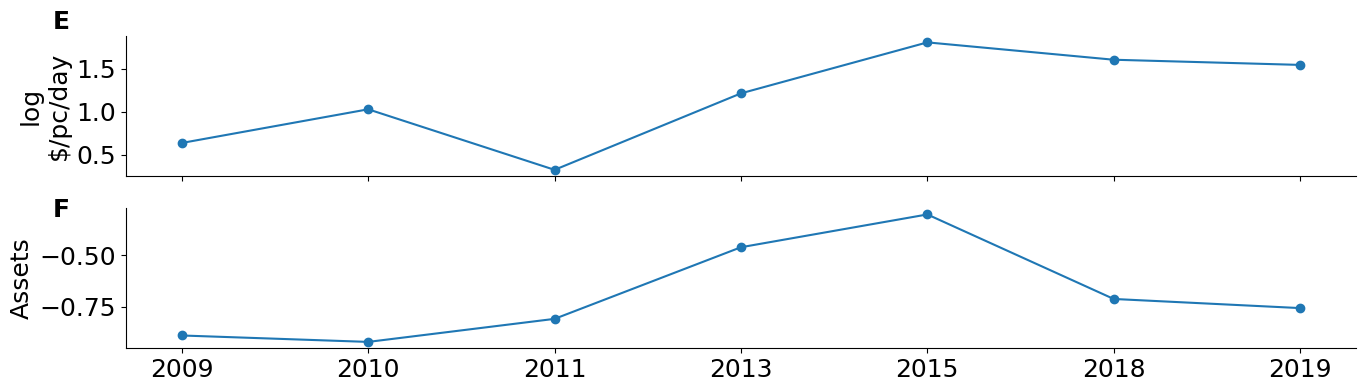

In [37]:
t_fig, t_ax = plt.subplots(2,1, figsize = (14,4), sharex = True)

# subset the data
sub_df = lsms_df[lsms_df['cluster_id'] == cluster_id].reset_index(drop = True).sort_values('start_year').copy()
sub_df['plot_index'] = range(len(sub_df))

t_fig.subplots_adjust(left=-.5)


t_ax[0].spines[['right', 'top']].set_visible(False)
t_ax[1].spines[['right', 'top']].set_visible(False)

t_ax[0].plot(sub_df['plot_index'], sub_df['log_mean_pc_cons_usd_2017'])
t_ax[0].scatter(sub_df['plot_index'], sub_df['log_mean_pc_cons_usd_2017'])

t_ax[1].plot(sub_df['plot_index'], sub_df['mean_asset_index_yeh'])
t_ax[1].scatter(sub_df['plot_index'], sub_df['mean_asset_index_yeh'])
t_ax[1].set_xticks(ticks = sub_df['plot_index'],labels = sub_df['start_year'])

t_ax[0].set_ylabel('log\n\$/pc/day')
t_ax[1].set_ylabel('Assets')


t_fig.text(0.05, .95, 'E', weight='bold', size = 18)
t_fig.text(0.05, 0.48, 'F', weight='bold', size = 18)

plt.tight_layout()

pth = '../figures/tabular_features/targets.png'
plt.savefig(pth, dpi = 500, bbox_inches = 'tight')